In [1]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html
import torch

opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='test'
opt.netG='unet_256'
#opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all/'
opt.dataset_mode='aligned'
opt.name='1207_vae_sat_all'
opt.norm='batch'
opt.input_nc=8+1
opt.output_nc=3
opt.preprocess="none"
sat_model = create_model(opt)
sat_model.setup(opt)
sat_model.eval()
sat_model=sat_model.netG


----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: None                          
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                             	[default: 0]
 

In [2]:
import importlib
import models
# importlib.reload(models)
opt.model='vae_pix2pix'
#opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all_med1-29/'
opt.name='1213_vae_hei_all'
#opt.name='test0606_2'
opt.input_nc=1
opt.output_nc=1
hei_model = models.create_model(opt)
hei_model.setup(opt)
hei_model.eval()
hei_model=hei_model.netG

latent_mean, U=torch.load('latent_data/1207')

device='cuda:0'
U=U.to(device).float()
latent_mean = latent_mean.to(device).float()
latent = latent_mean
print(latent.shape)

initialize network with normal
model [VAEPix2PixModel] was created
loading the model from ./checkpoints/1213_vae_hei_all/latest_net_S.pth
loading the model from ./checkpoints/1213_vae_hei_all/latest_net_G.pth
---------- Networks initialized -------------
[Network S] Total number of parameters : 2.849 M
[Network G] Total number of parameters : 54.416 M
-----------------------------------------------
torch.Size([16])


In [ ]:
import torch
import json
import random
import string
import pathlib
import base64
import re
from io import BytesIO
from PIL import Image
from flask import Flask, request, send_file, redirect, render_template, Response
from flask_socketio import SocketIO
import numpy as np

app = Flask(__name__)



def delete_img():
    folder = "static/result"
    images = os.listdir(folder)
    if len(images) >= 20:
        for image in images[:10]:
            os.remove(os.path.join(folder, image))

import torchvision
cs=256
cs2=cs**2
scale=0.07
bias_r=0.3
transform=torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.to(device)),
    torchvision.transforms.Lambda(lambda x: (x[0]-bias_r+x[1]/cs+x[2]/cs2).unsqueeze(0).unsqueeze(0)),
    
    ]
)

@app.route("/", methods=["GET"])
def index():
    return 'Server avaliable'

def getImage(base64string):
    return transform(Image.open(BytesIO(base64.b64decode(re.sub('^data:image/.+;base64,', '', base64string)))).convert("RGB"))

def tensor2im_24(v, imtype=np.uint8):
#     print(v.shape)
    v = v.data[0][0]
    v=torch.stack([v- ((v * cs) % 1) / cs + bias_r, ((v * cs) % 1) - (((v * cs2) % 1) / cs), (v * cs2) % 1], dim=0)
    image_numpy = v.cpu().float().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0
    return image_numpy.astype(imtype)

def tensor2im(v, imtype=np.uint8):
    v = v.data[0]
    image_numpy = v.cpu().float().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0
    return image_numpy.astype(imtype)



@app.route("/generate", methods=["POST"])
def generate():
    global X,Y,latent,sat
    delete_img()
    path = "static/result"
    pathlib.Path('static/result').mkdir(parents=True, exist_ok=True)
    X = getImage(request.json['structure'])
    bias=(X.min()+X.max())/2
    X=(X-bias)/scale

    
    latent = torch.cat([getImage(request.json['latent'][i])for i in range(4)],dim=1)*20
    h, w=latent.shape[2],latent.shape[3]
    latent=torch.mm(U[:,:latent.shape[1]],latent.view(latent.shape[1],-1)).view(1,-1,h,w)+latent_mean.view(1,-1,1,1)
    Y = hei_model(torch.cat([X,latent[:,8:]],dim=1))[:,0:1]
    #Y = hei_model(X)[:,0:1]
    print(Y.min(), Y.max())
    sat = sat_model(torch.cat([Y,latent[:,:8]],dim=1))
    print(sat.shape)
    print(sat.min(), sat.max())
    hei_array = tensor2im_24(Y * scale + bias)
    hei_image = Image.fromarray(hei_array,"RGB")
    hei_name = ''.join(random.choice(string.ascii_lowercase) for i in range(6))+'.png'              
    hei_image.save(os.path.join(path, hei_name))
    
    sat_array = tensor2im(sat/2+0.5)
    sat_image = Image.fromarray(sat_array,"RGB")
    sat_name = ''.join(random.choice(string.ascii_lowercase) for i in range(6))+'.png'              
    sat_image.save(os.path.join(path, sat_name))
    
    resp = {
        'hei_path': path+'/'+hei_name,
        'sat_path': path+'/'+sat_name,
    }
    
    return Response(json.dumps(resp), mimetype="application/json")


socketio = SocketIO(app, cors_allowed_origins='*')
app.run(debug=False, host='0.0.0.0', port=81)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:81/ (Press CTRL+C to quit)
59.120.178.253 - - [18/Dec/2020 05:29:49] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:29:49] "GET /static/result/vfchqk.png HTTP/1.1" 200 -


tensor(-0.0411, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0638, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9977, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9934, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:29:49] "GET /static/result/viakfh.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:29:58] "POST /generate HTTP/1.1" 200 -


tensor(-0.1618, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.2129, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9673, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9935, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:29:58] "GET /static/result/pufydk.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:29:58] "POST /generate HTTP/1.1" 200 -


tensor(-0.1618, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.2129, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9673, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9935, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:29:59] "GET /static/result/goirna.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:29:59] "GET /static/result/pawtak.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:00] "GET /static/result/eidebw.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:07] "POST /generate HTTP/1.1" 200 -


tensor(-0.3310, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4534, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.8508, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9932, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:30:07] "GET /static/result/ggnoxc.png HTTP/1.1" 404 -
59.120.178.253 - - [18/Dec/2020 05:30:07] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:07] "GET /static/result/dfggba.png HTTP/1.1" 200 -


tensor(-0.3310, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4534, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.8508, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9932, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:30:07] "GET /static/result/qrhhdb.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:16] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:16] "GET /static/result/rwslxh.png HTTP/1.1" 200 -


tensor(-0.3308, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4567, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.8977, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9936, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:30:17] "GET /static/result/ukbozg.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:22] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:22] "GET /static/result/bpgjwc.png HTTP/1.1" 200 -


tensor(-0.3310, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4604, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.8594, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9930, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:30:22] "GET /static/result/jkaktj.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:25] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:25] "GET /static/result/wndqyu.png HTTP/1.1" 200 -


tensor(-0.3310, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4618, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.8634, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9919, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:30:26] "GET /static/result/aqygxz.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:30] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:30] "GET /static/result/wvheus.png HTTP/1.1" 200 -


tensor(-0.3309, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4474, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.8533, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9926, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:30:30] "GET /static/result/drtpke.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:35] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:35] "GET /static/result/bbkanr.png HTTP/1.1" 200 -


tensor(-0.3307, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4472, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.8582, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9928, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:30:35] "GET /static/result/pzwktc.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:38] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:38] "GET /static/result/xsxkxl.png HTTP/1.1" 200 -


tensor(-0.3307, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4463, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.8585, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9931, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:30:38] "GET /static/result/hfgvuu.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:44] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:44] "GET /static/result/ngwcfb.png HTTP/1.1" 200 -


tensor(-0.3296, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4463, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.8640, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9933, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.3296, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4463, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.8640, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9933, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:30:44] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:45] "GET /static/result/ptqycq.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:45] "GET /static/result/pqbbrm.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:45] "GET /static/result/xxvhnq.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:51] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:51] "GET /static/result/kpafin.png HTTP/1.1" 200 -


tensor(-0.3444, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4764, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9317, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9963, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:30:51] "GET /static/result/sdqbvr.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:55] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:30:55] "GET /static/result/eoailh.png HTTP/1.1" 200 -


tensor(-0.3727, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4732, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9802, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9937, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:30:56] "GET /static/result/ewfxlt.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:01] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:01] "GET /static/result/jdxxst.png HTTP/1.1" 200 -


tensor(-0.3731, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4791, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9793, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9941, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:31:02] "GET /static/result/utqoir.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:04] "POST /generate HTTP/1.1" 200 -


tensor(-0.3728, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4795, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9543, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9936, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:31:05] "GET /static/result/ghikrh.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:05] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:05] "GET /static/result/wqoflw.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:05] "GET /static/result/wltmke.png HTTP/1.1" 200 -


tensor(-0.3728, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4795, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9543, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9936, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:31:06] "GET /static/result/unimrw.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:09] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:09] "GET /static/result/lpvygh.png HTTP/1.1" 200 -


tensor(-0.3717, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4836, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9781, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9955, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:31:09] "GET /static/result/rxnzxl.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:17] "POST /generate HTTP/1.1" 200 -


tensor(-0.3750, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4830, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9794, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9957, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:31:17] "GET /static/result/taynnv.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:17] "GET /static/result/aqtkca.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:26] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:26] "GET /static/result/rybewi.png HTTP/1.1" 200 -


tensor(-0.3752, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4829, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9794, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9957, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:31:26] "GET /static/result/pgigxq.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:31] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:31] "GET /static/result/lfyysa.png HTTP/1.1" 200 -


tensor(-0.3752, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4829, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9794, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9957, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:31:32] "GET /static/result/otxptw.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:35] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:35] "GET /static/result/tjcnhz.png HTTP/1.1" 200 -


tensor(-0.3712, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6466, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9900, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9990, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:31:35] "GET /static/result/qcprmd.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:54] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:31:54] "GET /static/result/vlpuli.png HTTP/1.1" 200 -


tensor(-0.5125, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7936, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9510, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9968, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:31:55] "GET /static/result/ofllnj.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:32:02] "POST /generate HTTP/1.1" 200 -


tensor(-0.5125, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7936, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9510, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9968, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:32:02] "GET /static/result/shfkhe.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:32:03] "GET /static/result/xwrjmy.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:32:05] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:32:05] "GET /static/result/ytdidr.png HTTP/1.1" 200 -


tensor(-0.3873, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6515, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9748, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9990, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:32:05] "GET /static/result/shinyc.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:32:09] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:32:09] "GET /static/result/acztcy.png HTTP/1.1" 200 -


tensor(-0.3866, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6491, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9754, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9989, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:32:10] "GET /static/result/nuesbk.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:32:11] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:32:11] "GET /static/result/eakniw.png HTTP/1.1" 200 -


tensor(-0.3885, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6552, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9704, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9983, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:32:12] "GET /static/result/tfzcpi.png HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:32:23] "POST /generate HTTP/1.1" 200 -
59.120.178.253 - - [18/Dec/2020 05:32:23] "GET /static/result/hyhjsu.png HTTP/1.1" 200 -


tensor(-0.4552, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6995, device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([1, 3, 256, 256])
tensor(-0.9474, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.9974, device='cuda:0', grad_fn=<MaxBackward1>)


59.120.178.253 - - [18/Dec/2020 05:32:23] "GET /static/result/wkmvci.png HTTP/1.1" 200 -


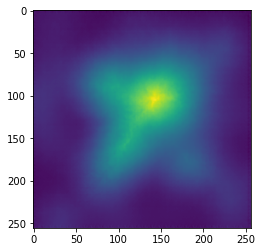

In [8]:
plt.imshow(Y[0, 0].cpu().detach())
plt.colorbar()

In [7]:
import matplotlib.pyplot as plt
plt.imshow(sat_model(torch.cat([Y,latent[:,:16]],dim=1))[0].transpose(0,2).cpu().detach()/2+0.5)
plt.colorbar()

RuntimeError: Given groups=1, weight of size [64, 9, 4, 4], expected input[1, 17, 256, 256] to have 9 channels, but got 17 channels instead

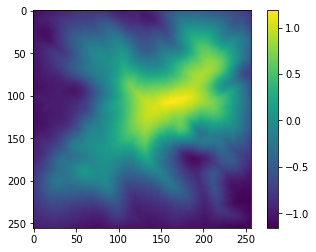

In [60]:
plt.imshow(hei_model(torch.cat([X*1,up(latent_hei[5])*0],dim=1))[0,0].cpu().detach())
plt.colorbar()

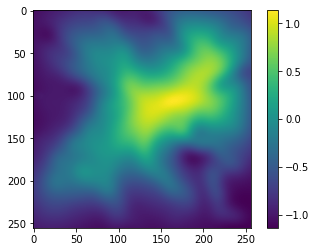

In [27]:
import matplotlib.pyplot as plt
plt.imshow(X[0,0].cpu().detach())
plt.colorbar()

In [20]:
up=torch.nn.Upsample(size=[256,256])

In [153]:
(sat.min(),sat.max())

(tensor(-0.9618, device='cuda:0', grad_fn=<MinBackward1>),
 tensor(0.8859, device='cuda:0', grad_fn=<MaxBackward1>))

In [3]:
(torch.mm(U.t(),latent[a:a+d].t().cpu().double())).t().shape

NameError: name 'latent' is not defined

In [33]:
import torch
latent_hei=torch.load('latent_data/lat10')

In [33]:
(latent-latent.mean(0))

tensor([-9.7228e-02,  4.5485e-02, -2.5228e-01, -1.3564e-01, -2.3248e-02,
        -7.8469e-02,  1.7260e-02,  8.1414e-02, -6.4035e-02, -1.0142e-01,
        -1.2557e-03, -1.4185e-01, -5.5843e-02,  1.4802e-01, -4.2049e-02,
        -9.7208e-02, -2.4463e-02,  7.7214e-01,  1.2428e+00, -5.3769e-01,
        -1.0978e+00,  1.3108e+00, -1.3921e+00,  1.0719e+00,  5.3930e-01,
        -5.8487e-01,  1.0161e+00, -1.6145e-01,  4.7305e-01, -3.0348e-01,
        -8.4524e-01,  4.5087e-01], device='cuda:0')

In [10]:
plt.imshow(U)
plt.colorbar()

NameError: name 'plt' is not defined

In [4]:
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='vae_pix2pix'
opt.netG='unet_256'
opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all/'
opt.dataset_mode='aligned'
opt.name='1026_vae_sat_all'
opt.norm='batch'
opt.input_nc=1
opt.output_nc=3
opt.preprocess=[]
sat_model = create_model(opt)
sat_model.setup(opt)

opt.phase='train'
train_dataset = create_dataset(opt)


initialize network with normal
model [VAEPix2PixModel] was created
loading the model from ./checkpoints/1026_vae_sat_all/latest_net_S.pth
loading the model from ./checkpoints/1026_vae_sat_all/latest_net_G.pth
---------- Networks initialized -------------
[Network S] Total number of parameters : 2.956 M
[Network G] Total number of parameters : 54.428 M
-----------------------------------------------
dataset [AlignedDataset] was created


In [5]:
torch.load('latent_data/mean_and_pca')

(tensor([-9.7228e-02,  4.5485e-02, -2.5228e-01, -1.3564e-01, -2.3248e-02,
         -7.8469e-02,  1.7260e-02,  8.1414e-02, -6.4035e-02, -1.0142e-01,
         -1.2557e-03, -1.4185e-01, -5.5843e-02,  1.4802e-01, -4.2049e-02,
         -9.7208e-02, -2.4463e-02,  7.7214e-01,  1.2428e+00, -5.3769e-01,
         -1.0978e+00,  1.3108e+00, -1.3921e+00,  1.0719e+00,  5.3930e-01,
         -5.8487e-01,  1.0161e+00, -1.6145e-01,  4.7305e-01, -3.0348e-01,
         -8.4524e-01,  4.5087e-01], device='cuda:0'),
 tensor([[-2.8590e-04,  7.4155e-04, -1.8919e-03, -1.0745e-03, -2.6615e-04,
           3.1679e-04, -9.2807e-04, -1.9652e-04, -9.1979e-06,  1.2728e-03],
         [-4.9969e-05, -3.5608e-03,  6.7265e-03,  3.7181e-03,  1.4317e-03,
          -1.2793e-03,  2.4091e-03,  1.4536e-03,  1.0665e-03, -1.7452e-03],
         [ 1.4359e-01,  1.7924e-01,  6.0120e-01, -2.4677e-02, -4.3563e-01,
          -1.5963e-02, -1.4013e-01, -1.1598e-01,  2.2241e-01, -2.7973e-01],
         [-2.6112e-03, -1.1537e-03, -2.7220e-02, 

In [9]:
[torch.mean(latent.t()[i])for i in range(32)]

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [134]:
torch.var(torch.tensor([[1,2.]]))

tensor(0.5000)

14432664.319664817


In [18]:
model.netS.module.upsampler(latent[0][0:16].view(1,1,4,4)).shape

NameError: name 'model' is not defined

In [19]:
slider = torch.tensor([[0.]*10]).float()
slider[0,0] = 1
slider[0,1] = -1
latent = torch.mm(U,slider.t())


In [119]:
14432664

0.30000000000000004

In [212]:
model.forward(latent)

tensor([[0.3000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], dtype=torch.float64)

0it [00:00, ?it/s]


In [18]:
import torch
model.set_input(data)
model.forward(torch.tensor([[-0.0010],
        [ 0.5],
        [-0.0356],
        [-0.0015],
        [-0.0081],
        [ 0.0255],
        [0.3],
        [ 0.0295],
        [-0.0169],
        [-0.0107],
        [ 0.1654],
        [0.5],
        [ 0.0121],
        [-0.3842],
        [ 0.0416],
        [ 0.3695]]*16, dtype=torch.float).cuda())

In [22]:
import torchvision
def p(x):
    return torchvision.transforms.ToPILImage()(x[0].detach().cpu()/2+0.5)

In [23]:
p(model.get_current_visuals()['fake_B'])

NameError: name 'model' is not defined

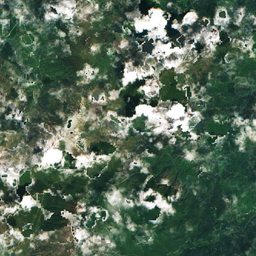

In [254]:
p(model.get_current_visuals()['real_B'])

In [25]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html

opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='vae_pix2pix'
opt.netG='unet_256'
opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all/'
opt.dataset_mode='aligned'
opt.name='1026_vae_sat_all'
opt.norm='batch'
opt.input_nc=1
opt.output_nc=3
opt.preprocess=[]
sat_model = model.create_model(opt)
sat_model.setup(opt)

opt.phase='train'
train_dataset = create_dataset(opt)
opt.phase='val'
val_dataset = create_dataset(opt)
opt.phase='test'
test_dataset = create_dataset(opt)
from tqdm import tqdm
mius_sat=[]
model=sat_model
model.eval()

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: None                          
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                             	[default: 0]
 

NameError: name 'model' is not defined

In [21]:
U

NameError: name 'U' is not defined